<a href="https://colab.research.google.com/github/Berkay86/DeepPerson/blob/main/CHESSGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from zipfile import ZipFile
from google.colab import files
import os
     

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tfc
np.set_printoptions(suppress=True)
sess = tfc.InteractiveSession()

In [5]:
import cv2
import zipfile
import os

# Extract the contents of the zip file
file = "VİDEOLARIM.zip"
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall()

# Create a list to store the folder names
folder_names = []

# Iterate over each file in the current directory
for file in os.listdir():
    if file.endswith(".mp4"):
        # Open the video file
        cap = cv2.VideoCapture(file)

        # Create a folder name
        folder_name = os.path.splitext(file)[0]
        folder_names.append(folder_name)

        # Create a folder
        os.makedirs(folder_name)

        # Read every frame of the video
        i = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break

            # Save one frame per second
            if i % 30 == 0:
                image_file_name = folder_name + "/ " +str(i/30) + ' .jpg'
                cv2.imwrite(image_file_name, frame)
            i += 1

        # Close the video file
        cap.release()
        cv2.destroyAllWindows()

# Zip all the folders and their contents into a single zip file
result_file = "result.zip"
with zipfile.ZipFile(result_file, 'w') as zip_file:
    for folder_name in folder_names:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                zip_file.write(os.path.join(root, file))

FileNotFoundError: ignored

In [3]:
file2 = "/content/drive/MyDrive/RESULTS3.zip"

In [ ]:
with ZipFile(file2, 'r') as zip:
    zip.printdir()
    zip.extractall()
     

In [5]:
paths = os.listdir('RESULTS')
paths

['MorphyPaulsen4',
 'StauntonAnderssen',
 'BirdAnderssen1',
 'PaulsenMorphy',
 'MorphyPaulsen2',
 'PaulsenMorphy4',
 'MorphyPaulsen',
 'StauntonBird',
 'PaulsenMorphy1',
 'MorphyPaulsen1',
 'BirdAnderssen',
 'StauntonAnderssen1',
 'PaulsenMorphy2',
 'PaulsenMorphy3',
 'MorphyBird',
 'MorphyPaulsen3',
 'MorphyPaulsen5',
 'AnderssenStaunton2',
 'AnderssenStaunton1']

In [9]:
k=[]
images = []
labels = []
m=[] 
a=[] 
     

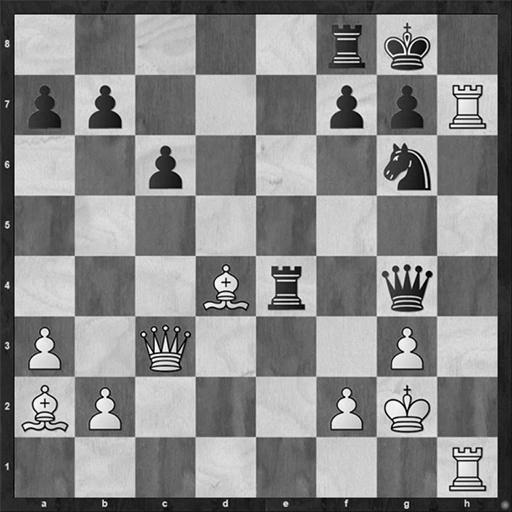

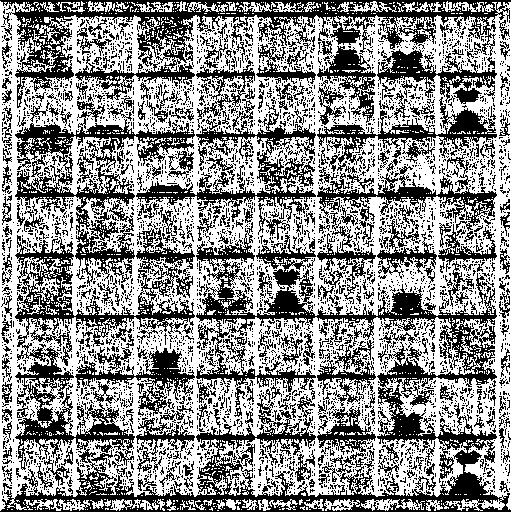

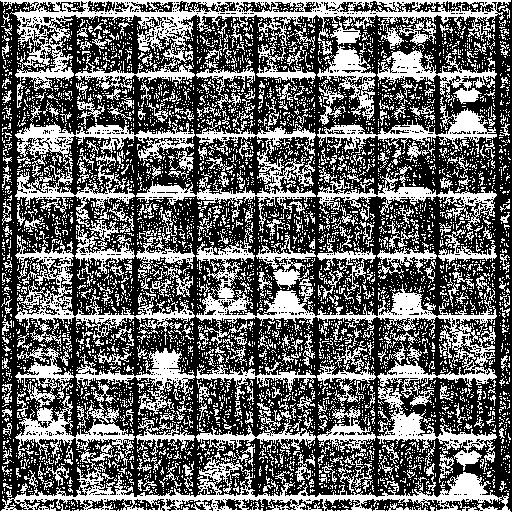

In [97]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd
import scipy.signal

def display_array(a, fmt='jpeg', rng=[0,1]):
    a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

for i in paths:
    path0 = '/content/RESULTS/'+ str(i)
    for path in os.listdir(path0):
        path = '/content/RESULTS/'+ str(i) + "/" + path
        #print(path)
        img = plt.imread(path)
        img = PIL.Image.fromarray(img)
        if img.size[0] > 2000 or img.size[1] > 2000:
            print("Image too big (%d x %d)" % (img.size[0], img.size[1]))
            new_size = 500.0 # px
            if img.size[0] > img.size[1]:
                # resize by width to new limit
                ratio = new_size / img.size[0]
            else:
                # resize by height
                ratio = new_size / img.size[1]
            print("Reducing by factor of %.2g" % (1./ratio))
            img = img.resize((int(img.size[0] * ratio), int(img.size[1] * ratio)), PIL.Image.ADAPTIVE)
            print("New size: (%d x %d)" % (img.size[0], img.size[1]))
        img = np.asarray(img)
        img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

display_array(img, rng=[0,255])

a=img

def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def gradientx(x):
  """Compute the x gradient of an array"""
  gradient_x = make_kernel([[-1.,0., 1.],
                            [-1.,0., 1.],
                            [-1.,0., 1.]])
  return simple_conv(x, gradient_x)

def gradienty(x):
  """Compute the x gradient of an array"""
  gradient_y = make_kernel([[-1., -1, -1],[0.,0,0], [1., 1, 1]])
  return simple_conv(x, gradient_y)

def corners(x):
  """Find chess square corners in an array"""
  chess_corner = make_kernel([[-1., 0, 1],[0., 0., 0.], [1.,0, -1]])
  return simple_conv(x, chess_corner)

# Following are meant for binary images
def dilate(x, size=3):
  """Dilate"""
  kernel = make_kernel(np.ones([size,size], dtype=np.float32))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(1),
                          np.float32(2))-np.float32(1)

def erode(x, size=3):
  """Erode"""
  kernel = make_kernel(np.ones([size,size]))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(size*size-1),
                          np.float32(size*size))-np.float32(size*size-1)

def opening(x, size=3):
    return dilate(erode(x,size),size)

def closing(x, size=3):
    return erode(dilate(x,size),size)

def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)
    
import tensorflow.compat.v1 as tf

# Cast the input tensor to float32
A = tf.cast(a, tf.float32)

# Compute X & Y gradients and subtract opposite gradient
Dx = tf.clip_by_value(tf.abs(gradientx(A)) - tf.abs(gradienty(A)), 0., 1.)
Dy = tf.clip_by_value(tf.abs(gradienty(A)) - tf.abs(gradientx(A)), 0., 1.)

# Compute the corner response
Dxy = tf.abs(gradientx(A) * gradienty(A))
Dc = tf.abs(corners(A))

import numpy as np
import tensorflow.compat.v1 as tf

# ... Hough dönüşümü işlemleri ...

sess = tf.compat.v1.InteractiveSession()
tf.compat.v1.global_variables_initializer()
dx = Dx.numpy()
dy = Dy.numpy()
dx_min = np.min(dx)
dx_max = np.max(dx)
dy_min = np.min(dy)
dy_max = np.max(dy)
display_array(dx, rng=[dx_min, dx_max])
display_array(dy, rng=[dy_min, dy_max])
sess.close()

